In [1]:
from tensorflow import keras
import tensorflow as tf
import os,random

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from kerastuner.tuners import Hyperband
from kerastuner.engine.hyperparameters import HyperParameters


os.environ["CUDA_VISIBLE_DEVICES"] = '0'   #指定第一块GPU可用
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9  # 程序最多只能占用指定gpu50%的显存
config.gpu_options.allow_growth = True      #程序按需申请内存
sess = tf.compat.v1.Session(config = config)


train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_dir = '/.../horse-or-human/'
validation_dir = '/.../validation-horse-or-human/'
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150,150),
    batch_size=16,
    class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


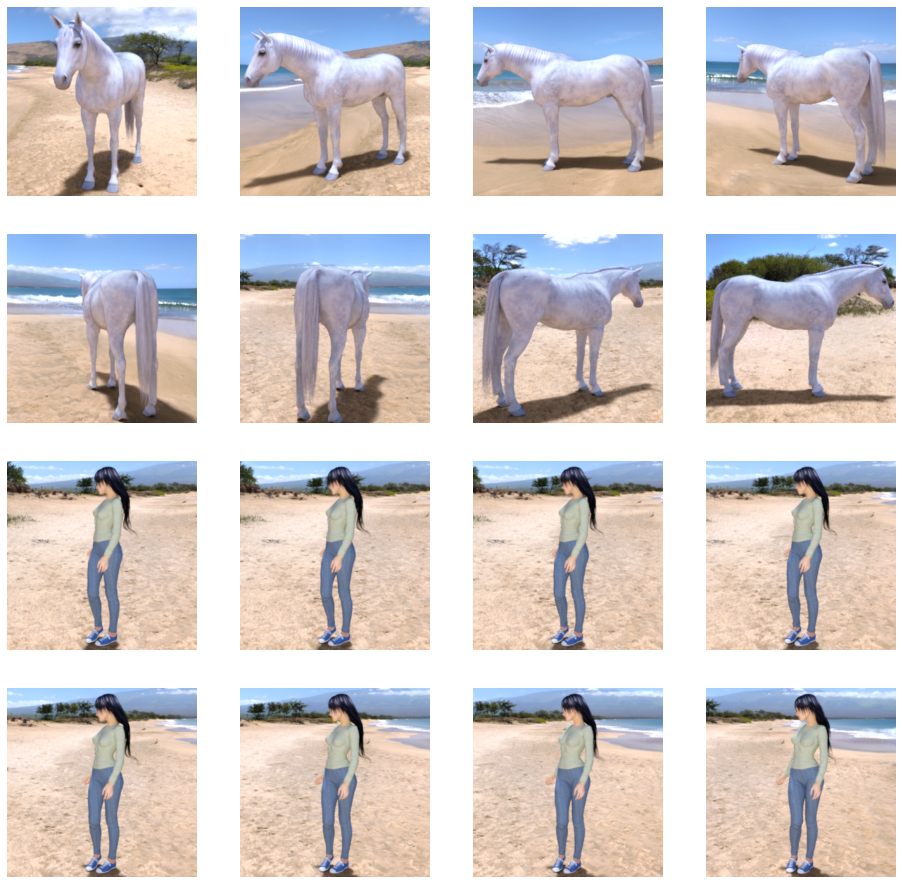

In [2]:
# show first 8 pictures in each category
import matplotlib.pyplot as plt
import matplotlib.image as mping

nrows, ncols = 4, 4
pic_index = nrows*ncols//2

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

newx_horse_pic = [os.path.join(train_dir,'horses',fname) for fname in os.listdir(os.path.join(train_dir,'horses'))[:pic_index]]
newx_huamn_pic = [os.path.join(train_dir,'humans',fname) for fname in os.listdir(os.path.join(train_dir,'humans'))[:pic_index]]

for i,img in enumerate(newx_horse_pic+newx_huamn_pic):
    sp = plt.subplot(nrows,ncols, i+1)
    sp.axis('Off')
    img = mping.imread(img)
    plt.imshow(img)
plt.show()

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.001),metrics=['acc'])

history = model.fit(
    train_generator, 
    epochs=7, # 容易过度拟合
    verbose=1,
    validation_data = validation_generator,
    validation_steps=8
    )


Epoch 1/10
65/65 [==============================] - 15s 225ms/step - loss: 0.3926 - acc: 0.8014 - val_loss: 0.4737 - val_acc: 0.8125
Epoch 2/10
65/65 [==============================] - 15s 230ms/step - loss: 0.2074 - acc: 0.9299 - val_loss: 0.7134 - val_acc: 0.8281
Epoch 3/10
65/65 [==============================] - 19s 288ms/step - loss: 0.0938 - acc: 0.9727 - val_loss: 1.0569 - val_acc: 0.8438
Epoch 4/10
65/65 [==============================] - 17s 263ms/step - loss: 0.0936 - acc: 0.9718 - val_loss: 2.5900 - val_acc: 0.7969
Epoch 5/10
65/65 [==============================] - 17s 258ms/step - loss: 0.0698 - acc: 0.9776 - val_loss: 0.5269 - val_acc: 0.9062
Epoch 6/10
65/65 [==============================] - 17s 258ms/step - loss: 0.0355 - acc: 0.9883 - val_loss: 1.2998 - val_acc: 0.8672
Epoch 7/10
65/65 [==============================] - 16s 244ms/step - loss: 0.0660 - acc: 0.9864 - val_loss: 1.7621 - val_acc: 0.8125
Epoch 8/10
65/65 [==============================] - 16s 249ms/step - 

In [9]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 72, 72, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 34, 34, 64)        9280      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 128)      

<Figure size 432x288 with 0 Axes>

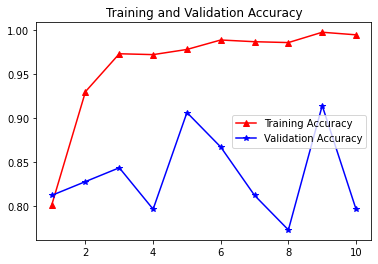

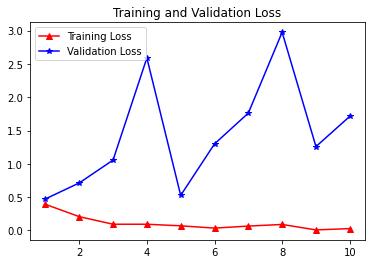

<Figure size 432x288 with 0 Axes>

In [34]:
loss,acc,val_loss,val_acc = history.history.values()
epochs = range(1,len(loss)+1)
import matplotlib.pyplot as plt

plt.plot(epochs,acc,'r-^',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b-*', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'r-^',label='Training Loss',color = 'red')
plt.plot(epochs,val_loss,'b-*',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()


In [37]:
## predicting images
from tensorflow.keras.preprocessing import image

# for fn in ['horse1-000.png','horse4-501.png']:
#     path = os.path.join(validation_dir,'horses') + fn

for fn in ['valhuman05-09.png','valhuman03-15.png']:
    path = os.path.join(validation_dir,'humans') + fn

    x = np.expand_dims(image.img_to_array(image.load_img(path, target_size=(150, 150))), axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    print(classes[0])
    if classes[0]>0.5:
        print(fn + " is a human")
    else:
        print(fn + " is a horse")

[1.]
valhuman05-09.png is a human
[1.]
valhuman03-15.png is a human


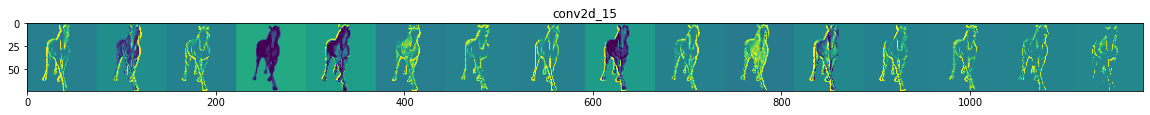

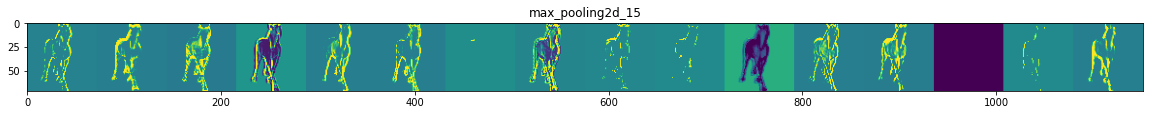

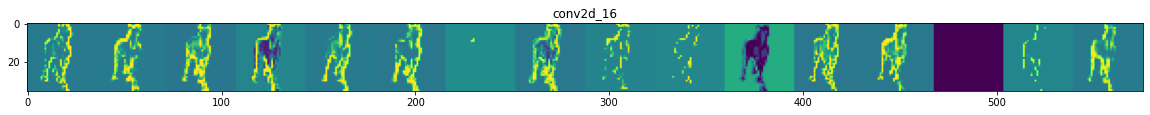

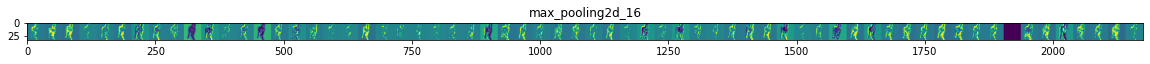

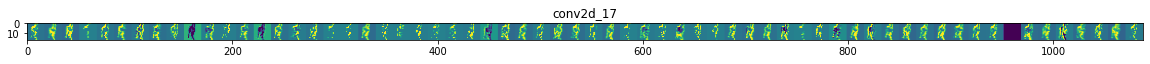

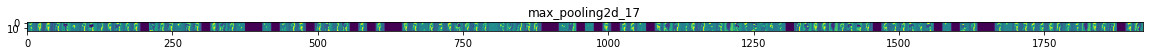

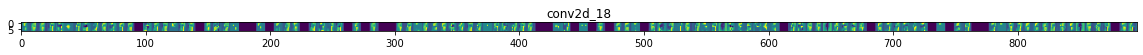

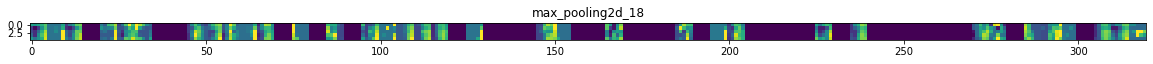

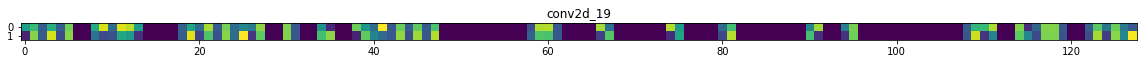

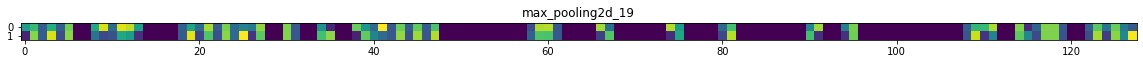

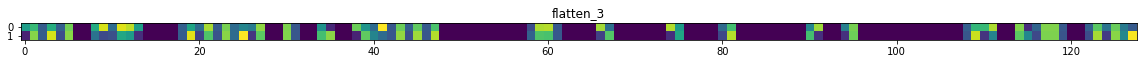

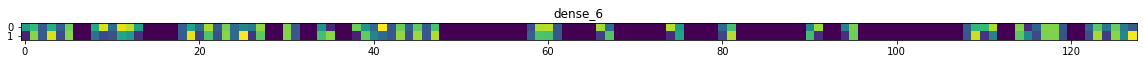

In [39]:
# visualization

from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_horse_dir,train_human_dir = os.path.join(validation_dir,'horses'),os.path.join(validation_dir,'humans')
train_horse_names,train_human_names = ['horse1-000.png','horse4-501.png'],['valhuman05-09.png','valhuman03-15.png']

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
  # Display the grid
  scale = 20. / n_features
  plt.figure(figsize=(scale * n_features, scale))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')